In [1]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from leap3d.contour import get_melting_pool_contour_2d, get_melting_pool_contour_3d
from leap3d.scanning.scan_parameters import ScanParameters
from leap3d.scanning.scan_results import ScanResults
from leap3d.config import DATA_DIR, PARAMS_FILEPATH, ROUGH_COORDS_FILEPATH


In [2]:
from matplotlib import animation


def get_contour_animation(scan_results, scan_parameters, t_start=0, t_end=None, t_stride=5):
    def get_ims(timestep):
        print(timestep, end='\r')
        for ax in axes[:-1]:
            ax.clear()
        ims_at_timestep = []
        coordinates, temperature = scan_results.get_interpolated_data(scan_parameters, timestep)
        laser_coordinates = scan_results.get_laser_coordinates_at_timestep(timestep)
        x_min = min(coordinates, key=lambda x: x[0])[0]
        y_min = min(coordinates, key=lambda x: x[1])[1]
        x_max = max(coordinates, key=lambda x: x[0])[0]
        y_max = max(coordinates, key=lambda x: x[1])[1]
        x_step_size = (x_max - x_min) / 256
        y_step_size = (y_max - y_min) / 256
        laser_x = (laser_coordinates[0] - x_min) / x_step_size
        laser_y = (laser_coordinates[1] - y_min) / y_step_size

        contours_2d = get_melting_pool_contour_2d(temperature, top_k=24)

        # 2D contour
        im = axes[0].imshow(temperature[:, :, -1], vmin=300, vmax=1500, cmap='hot', animated=True)
        ims_at_timestep.append(im)

        for contour in contours_2d[0]:
            im, = axes[0].plot(contour[:, 1], contour[:, 0], linewidth=2)
            ims_at_timestep.append(im)

        # Fake 3d contour
        for (depth, contour_layer) in enumerate(contours_2d):
            for contour in contour_layer:
                im, = axes[1].plot(contour[:, 0], contour[:, 1], 63 - depth, linewidth=2)
                ims_at_timestep.append(im)

        vertices_3d, faces_3d = get_melting_pool_contour_3d(temperature, top_k=24)

        if len(vertices_3d) == 0:
            return ims_at_timestep

        # 3D contour (vertices)
        im, = axes[2].plot(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], c='r', linewidth=2)
        ims_at_timestep.append(im)

        # 3D contour (faces)
        if len(axes[3].collections) == 0:
            mesh = Poly3DCollection(vertices_3d[faces_3d], linewidths=1, edgecolors='k', animated=True)
            axes[3].add_collection3d(mesh)
        else:
            axes[3].collections[0].set_verts(vertices_3d[faces_3d])

        for ax in axes[1:]:
            ax.set_xlim(laser_x - 15, laser_x + 15)
            ax.set_ylim(laser_y - 15, laser_y + 15)

        return ims_at_timestep

    fig = plt.figure(figsize=(24, 10))
    axes = []
    axes.append(fig.add_subplot(1, 4, 1))
    axes.append(fig.add_subplot(1, 4, 2, projection='3d'))
    axes.append(fig.add_subplot(1, 4, 3, projection='3d'))
    axes.append(fig.add_subplot(1, 4, 4, projection='3d'))

    for ax in axes[1:]:
        ax.set_zlim(40, 64)



    frames = ((t_end or scan_results.timesteps) - t_start) // t_stride
    ani = animation.FuncAnimation(fig, lambda t: get_ims(t_start + t*t_stride), frames=frames, repeat=True, interval=500, blit=True, repeat_delay=1000, save_count=2)

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(axes[0].get_images()[0], cax=cax, orientation='vertical')
    ani.save("./plots/contours.gif", fps=1, progress_callback=print)


In [4]:
scan_results = ScanResults(DATA_DIR / 'case_0000.npz')
timestep = 2000
scan_parameters = ScanParameters(PARAMS_FILEPATH, ROUGH_COORDS_FILEPATH, case_index=0)


C:\Users\matas\AppData\Local\Temp\ipykernel_14028\1349373973.py:72: UserWarning: You passed in an explicit save_count=2 which is being ignored in favor of frames=300.
  ani = animation.FuncAnimation(fig, lambda t: get_ims(t_start + t*t_stride), frames=frames, repeat=True, interval=500, blit=True, repeat_delay=1000, save_count=2)


MovieWriter ffmpeg unavailable; using Pillow instead.


0 300
1 300
2 300
3 300
4 300
5 300
6 300
7 300
8 300
9 300
10 300
11 300
12 300
13 300
14 300


KeyboardInterrupt: 

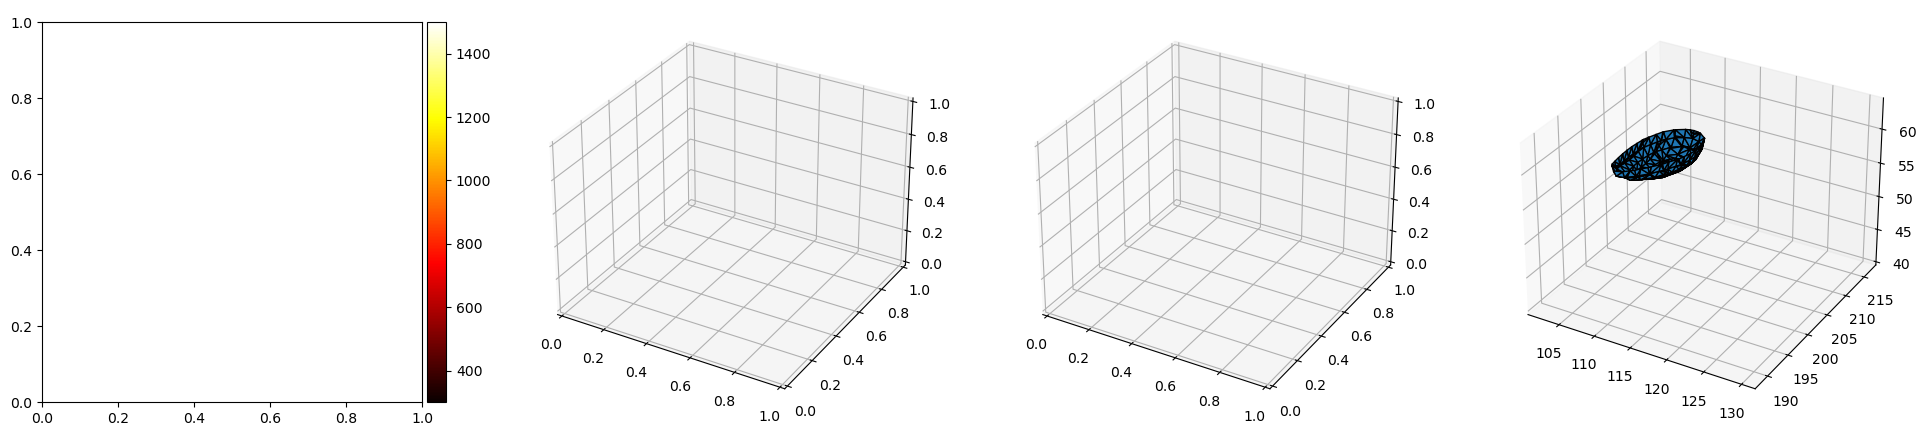

In [5]:
get_contour_animation(scan_results, scan_parameters, t_start=2000, t_end=3500, t_stride=5)